<a href="https://colab.research.google.com/github/nicolastibata/MINE_4210_ADL_202520/blob/main/labs/Laboratorio_8/MINE__4210_ADL_202520_L8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Logo ADL](https://github.com/nicolastibata/MINE_4210_ADL_202520/blob/main/docs/images/logo.png?raw=true)


# **Laboratorio 8: Autoencoder + Detección de Anomalías**
**Tutor: Nicolás Tibatá**

## **Tabla de Contenido**

[Contexto y objetivos](#scrollTo=5KnQpgpopi8a)<br>
[1. Introducción de los datos](#scrollTo=VjA8zwzJvmeO)<br>
[2. Preparación y Modelamiento](#scrollTo=kG8XHROzvuEH)<br>
[3. Preguntas](#scrollTo=JTKc52_Wvs_N)<br>

### **Contexto y Objetivos**

En este taller trabajaremos los autoencoders y sus aplicaciones. En este laboratorio usamos el dataset Fasion MNIST el cual contiene 70.000 imágenes 28x28 de diferentes prendas de vestir.

### **Objetivos**

1. **Entender el autoencoder** y sus ventajas.
2. **Aplicar una tarea de clasificación y detección de anomalías.**
4. **Revisar las diferentes formas de evaluación** del modelo.


**Datos:** [fashion-mnist](https://www.kaggle.com/datasets/zalando-research/fashionmnist)

### **1. Introducción a los datos**

In [1]:
# Instalación e Importación de librerías
!pip install ultralytics -q

import os
import glob
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image as PImage
from PIL import ImageDraw
from IPython.display import display

from google.colab import files
from google.colab import userdata

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import classification_report, confusion_matrix

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.4 MB/s eta 0:00:00


In [2]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

!kaggle datasets download -d zalando-research/fashionmnist
!unzip "fashionmnist.zip"

Dataset URL: https://www.kaggle.com/datasets/zalando-research/fashionmnist
License(s): other
  0% 0.00/68.8M [00:00<?, ?B/s]
100% 68.8M/68.8M [00:00<00:00, 1.70GB/s]
Archive:  fashionmnist.zip
  inflating: fashion-mnist_test.csv  
  inflating: fashion-mnist_train.csv  
  inflating: t10k-images-idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte  
  inflating: train-images-idx3-ubyte  
  inflating: train-labels-idx1-ubyte  


In [3]:
# 60.000 datos en entrenamiento
train = pd.read_csv('/content/fashion-mnist_train.csv', sep=',')
train

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# 10.000 datos en test
test = pd.read_csv('/content/fashion-mnist_test.csv', sep=',')
test

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0,0,0,0,0,0,0,0,0,0,...,32,23,14,20,0,0,1,0,0,0
9996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,2,52,23,28,0,0,0
9997,8,0,0,0,0,0,0,0,0,0,...,175,172,172,182,199,222,42,0,1,0
9998,8,0,1,3,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [5]:
# Separamos nuestas variables explicativas del target
x_train = train.drop('label', axis=1)
y_train = train['label']

x_test = test.drop('label', axis=1)
y_test = test['label']

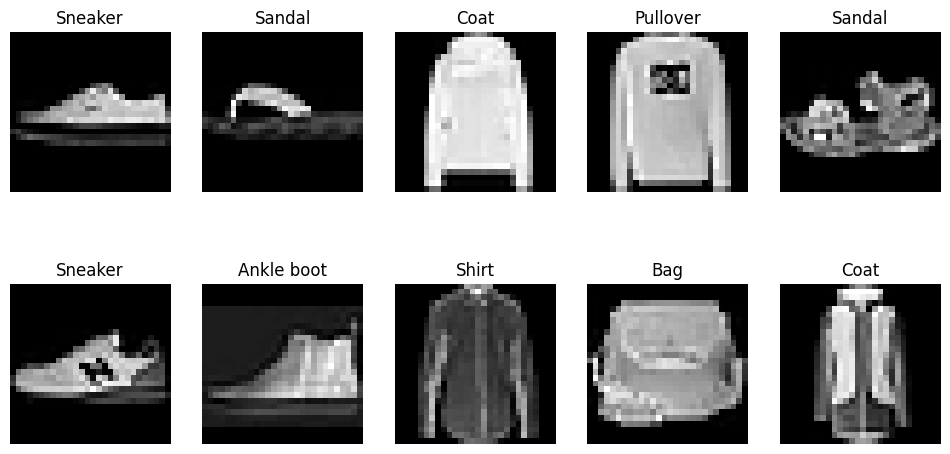

In [6]:
# El label original es numérico, lo convertimos a su label original
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]


random_sample = np.random.randint(0, len(x_train) + 1, size=10)

plt.figure(figsize=(12, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(x_train.iloc[random_sample[i]].values.reshape(28, 28), cmap='gray')
    plt.title(class_names[y_train[random_sample[i]]])
    plt.axis('off')
plt.show()

### **2. Preparación y Modelamiento**

#### **Preparación**

Normalizamos los valores de píxeles. Para disminuir el tiempo de convergencia durante el entrenamiento.

In [7]:
x_train = x_train / 255
x_test = x_test / 255

#### **Modelamiento**

In [8]:
autoencoder = Sequential()

# Capa de Entrada
autoencoder.add(Input(shape=(x_train.shape[1],), name='capa_entrada'))
# Encoder
autoencoder.add(Dense(256, activation='relu', name='encoder_1'))
autoencoder.add(Dense(128, activation='relu', name='encoder_2'))
# Espacio latente
autoencoder.add(Dense(64, activation='relu', name='espacio_latente'))
# Decoder
autoencoder.add(Dense(128, activation='relu', name='decoder_2'))
autoencoder.add(Dense(256, activation='relu', name='decoder_1'))
# Salida
autoencoder.add(Dense(x_train.shape[1], activation='sigmoid', name='capa_salida'))

In [9]:
autoencoder.compile(loss='binary_crossentropy', optimizer='adam')

In [10]:
# Veamos la construcción de nuestro modelo
autoencoder.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_1 (Dense)               │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_2 (Dense)               │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ espacio_latente (Dense)         │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_2 (Dense)               │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_1 (Dense)               │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_salida (Dense)             │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 484,944 (1.85 MB)

 Trainable params: 484,944 (1.85 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = autoencoder.fit(
    x_train,
    x_train,
    validation_split=0.2,
    batch_size=200,
    epochs=50
)

Epoch 1/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 0.4353 - val_loss: 0.3140
Epoch 2/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3075 - val_loss: 0.2997
Epoch 3/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2969 - val_loss: 0.2921
Epoch 4/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2912 - val_loss: 0.2887
Epoch 5/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2879 - val_loss: 0.2861
Epoch 6/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2844 - val_loss: 0.2838
Epoch 7/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2832 - val_loss: 0.2823
Epoch 8/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2817 - val_loss: 0.2803
Epoch 9/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2796 - val_loss: 0.2789
Epoch 10/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2790 - val_loss: 0.2783
Epoch 11/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2774 - val_loss: 0.2772
Epoch 12/50
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/st

Al usar el autoencoder completo realizamos una reconstrucción de la imagen.

In [12]:
x_recovered = autoencoder.predict(x_test, batch_size=100)
x_recovered[0].shape

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


(784,)

In [13]:
test_loss = autoencoder.evaluate(x_test, x_test)
print(f'Loss : {test_loss:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.2663
Loss : 0.27


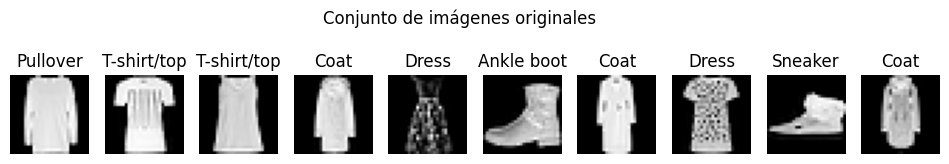

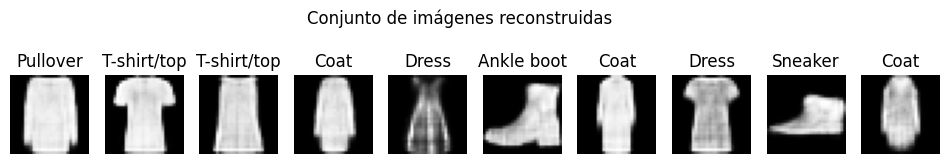

In [14]:
random_sample = np.random.randint(0, len(x_test) + 1, size=10)

# Conjunto de datos original
fig1, axs1 = plt.subplots(1, 10, figsize=(12, 6), sharey=True)
for i in range(10):
    axs1[i].imshow(x_test.iloc[random_sample[i]].values.reshape(28, 28), cmap='gray')
    axs1[i].set_title(class_names[y_test[random_sample[i]]])
    axs1[i].axis('off')
fig1.suptitle("Conjunto de imágenes originales")
fig1.subplots_adjust(top=1.5)

# Conjunto de datos recuperado
fig2, axs2 = plt.subplots(1, 10, figsize=(12, 6), sharey=True)
for i in range(10):
    axs2[i].imshow(x_recovered[random_sample[i]].reshape(28, 28), cmap='gray')
    axs2[i].set_title(class_names[y_test[random_sample[i]]])
    axs2[i].axis('off')
fig2.suptitle("Conjunto de imágenes reconstruidas")
fig2.subplots_adjust(top=1.5)

#### **Transferencia de Conocimiento**

Sin embargo, lo bueno del autoencoder es la capacidad de transferir conocimiento para otras aplicaciones como la clasificación o detección de anomalías. En el cual aprovechamos el espacio latente generado para poder usar ese conocimiento del modelo para otras tareas.

##### **Clasificación**

Para clasificar no necesitamos una reconstrucción de la imagen sino las características más importantes de cada tipo de imagen para poder cumplir con la tarea.

In [15]:
encoder = Sequential()

for layers in autoencoder.layers:
    if "decoder" in layers.name:
        break
    print(layers.name)
    layers.trainable = False
    encoder.add(layers)

encoder_1
encoder_2
espacio_latente


In [16]:
clf = Sequential()
# Capa de entrada
clf.add(Input(shape=(x_train.shape[1],), name='capa_entrada'))
# Encoder
clf.add(encoder)
# Capa oculta
clf.add(Dense(50, activation='relu', name='capa_oculta'))
# Capa de salida
clf.add(Dense(10, activation='softmax', name='capa_salida'))

In [17]:
clf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
clf.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (None, 64)             │       242,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_oculta (Dense)             │ (None, 50)             │         3,250 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ capa_salida (Dense)             │ (None, 10)             │           510 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,872 (960.44 KB)

 Trainable params: 3,760 (14.69 KB)

 Non-trainable params: 242,112 (945.75 KB)

In [18]:
history = clf.fit(x_train,
                  y_train,
                  validation_split=0.2,
                  batch_size=200,
                  epochs=25)

Epoch 1/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4237 - loss: 2.0453 - val_accuracy: 0.7685 - val_loss: 0.6629
Epoch 2/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7827 - loss: 0.6152 - val_accuracy: 0.8025 - val_loss: 0.5546
Epoch 3/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8143 - loss: 0.5273 - val_accuracy: 0.8218 - val_loss: 0.5028
Epoch 4/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8262 - loss: 0.4841 - val_accuracy: 0.8314 - val_loss: 0.4756
Epoch 5/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8329 - loss: 0.4649 - val_accuracy: 0.8369 - val_loss: 0.4566
Epoch 6/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8379 - loss: 0.4491 - val_accuracy: 0.8387 - val_loss: 0.4504
Epoch 7/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8478 - loss: 0.4261 - val_accuracy: 0.8414 - val_loss: 0.4367
Epoch 8/25
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8456 - loss: 0.4263 - val_accuracy: 0.

In [19]:
y_pred = np.argmax(clf.predict(x_test), axis=1)
y_pred

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([0, 1, 2, ..., 8, 8, 2])

In [20]:
print(classification_report(y_true=y_test, y_pred=y_pred, target_names=class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.78      0.88      0.82      1000
     Trouser       0.97      0.98      0.98      1000
    Pullover       0.79      0.78      0.79      1000
       Dress       0.90      0.88      0.89      1000
        Coat       0.79      0.83      0.81      1000
      Sandal       0.95      0.93      0.94      1000
       Shirt       0.73      0.60      0.66      1000
     Sneaker       0.94      0.90      0.92      1000
         Bag       0.94      0.96      0.95      1000
  Ankle boot       0.90      0.96      0.93      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



##### **Detección de Anomalías**

En la detección de anomalías usamos nuestra arquitectura completa para poder identificar esas imágenes anómalas basándonos en el error de reconstrucción.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Average Reconstruction Loss for Normal Data: 0.04538364085547693


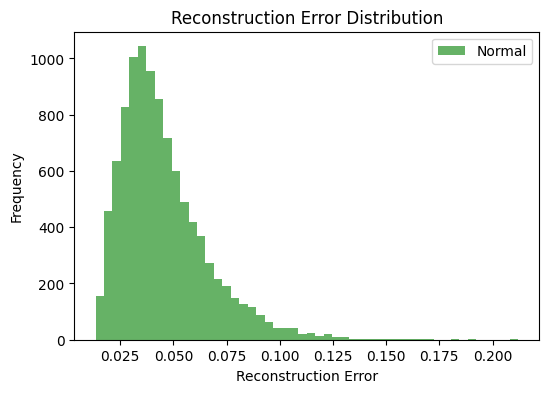

In [21]:
# Function que calcula la perdida de reconstrucción
def calculate_reconstruction_loss(data, model):
    reconstructions = model.predict(data)
    reconstruction_errors = np.mean(np.abs(data - reconstructions), axis=1)
    return reconstruction_errors

# Evaluamos el modelo
reconstruction_loss_normal = calculate_reconstruction_loss(x_test, autoencoder)
print(f"Average Reconstruction Loss for Normal Data: {np.mean(reconstruction_loss_normal)}")

# Visualizamos la distribución
plt.figure(figsize=(6, 4))
plt.hist(reconstruction_loss_normal, bins=50, alpha=0.6, color='g', label='Normal')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [22]:
anomalous_image = x_test.iloc[random_sample[0]].values.reshape(1, 784)
# Agregamos ruido aleatorio
noise = np.random.normal(loc=0.5, scale=0.5, size=anomalous_image.shape)
anomalous_image = np.clip(anomalous_image + noise, 0, 1)

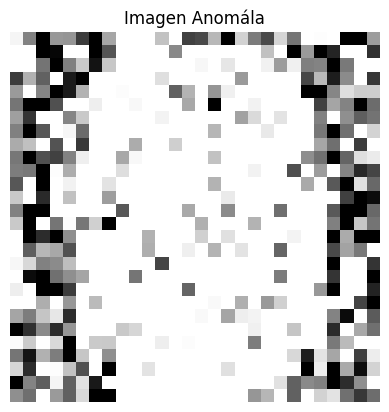

In [25]:
# Show the anomalous image
plt.imshow(anomalous_image.reshape(28, 28), cmap='gray')
plt.title('Imagen Anomála')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
Average Reconstruction Loss for Normal Data: 0.04538364085547693
Reconstruction Loss for Anomalous Data: 0.31884411884473846


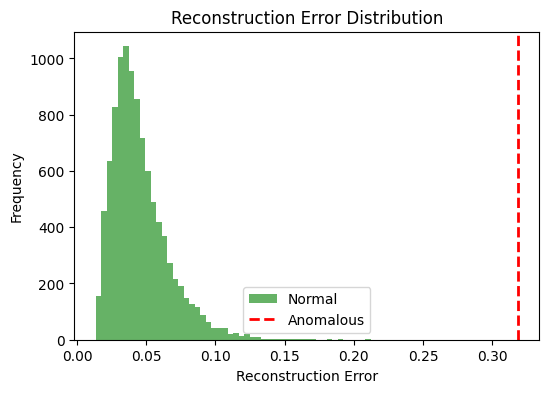

In [26]:
reconstruction_loss_anomalous = calculate_reconstruction_loss(anomalous_image, autoencoder)

print(f"Average Reconstruction Loss for Normal Data: {np.mean(reconstruction_loss_normal)}")
print(f"Reconstruction Loss for Anomalous Data: {reconstruction_loss_anomalous[0]}")

# Visualizamos la distribución con la anomalía
plt.figure(figsize=(6, 4))
plt.hist(reconstruction_loss_normal, bins=50, alpha=0.6, color='g', label='Normal')
plt.axvline(x=reconstruction_loss_anomalous[0], color='r', linestyle='dashed', linewidth=2, label='Anomalous')
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.show()

### **3. Preguntas**


1. Modifica la cantidad de capas y neuronas para el autoencoder. ¿Se puede obtener un valor de pérdida menor sobre el conjunto de test?

2. Igualmente, puedes hacer una red más profunda para el clasificador. ¿Agregar más capas después del encoder ayuda a mejorar el desempeño del modelo de clasificación?

4. ¿En cuáles escenarios consideran importante aplicar este tipo de arquitectura?